# Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods

## Introduction/Business problem

The health industry and its related businesses have been growing steadily during the past few decades in North America. Given the soaring awareness of personal healthcare and pursuits of healthy lifestyles, new business interests emerge in those big metropolitan areas which cover a wide range of products and services. In this project, we investigate and compare the potential investment opportunities for healthy food business in two major financial centers: New York city and the city of Toronto. Since the recent legalization of recreational marijuana in Canada and an increasing number of states in the U.S., cannabis and other natural herb based heath products are given more attention as diet supplement and health improvement alternatives. So here we want to forecast and compare the business potential of cannabis related heath products in those cities by studying the heath lifestyle preference  statistics and based on that, further identify the most promising locations of our new business.

## Dataset used in the project

The dataset is obtained using queries of Foursquare API. We will explore boroughs and neighborhoods in NYC and Toronto by using GET() method to obtain top venues nearby each location. Focuses will be placed on those health related venues that indicate people’s preference for a healthy lifestyle and openness to the idea of cannabis related products. The types of the locations include:

•  Gym <br>
•  Vegan restaurant<br>
•  Sports center<br>
•  Playground<br>
•  Health food store<br>
•  Fast food restaurant<br>
•  Sports gear/equipment store<br>
•  Cannabis lounges<br>
•  Bars/nightclubs<br>
•  Concerts/music festivals<br>

For the above listed venue types, we get visit related information, such as visitor age, gender, number of visits per day/month, etc.

To establish a fair comparison between the two cities, we want to normalize the data against demographic statistics, such as population and age structure of the two cities. The venue type statistics and the associated visit information will be used as the features for segmenting/clustering of boroughs and neighborhoods. 

## Data Acquisition and pre-processing

### 1. Import libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Load borough and neighborhood information of NYC and Toronto. Here we use the Manhattan and Downtown Toronto to represent NYC and Toronto respectively due to the limit of calls.

In [3]:
df_nyc = pd.read_csv('nyc_neighbourhoods.csv')
df_toronto = pd.read_csv('Toronto_Neighbourhood_and_Coordinates.csv')

In [4]:
df_nyc_main = df_nyc[df_nyc['Borough'] == 'Manhattan']
df_nyc_main.reset_index(drop = True, inplace = True)

df_toronto_main = df_toronto[df_toronto['Borough'] == 'Downtown Toronto']
df_toronto_main.reset_index(drop = True, inplace = True)

In [5]:
df_nyc_main.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Modify the Toronto dataset to match the structure with NYC dataset.

In [5]:
df_toronto_main.drop('PostalCode', axis = 1, inplace = True)
df_toronto_main.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [7]:
df_toronto_main.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,Downtown Toronto,St. James Town,43.651494,-79.375418
3,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383


### 2. Setup Foursquare API connections

Setup Foursquare API credentials.

In [8]:
CLIENT_ID = 'DRPWJPB40IVVKQBT41MULEGTN4WG5SJO4GDCG5XUPXJPRJHS' # your Foursquare ID
CLIENT_SECRET = 'OKEP4LQIQTJZL1K1CM4LHPLJ5X2JO2WQ4I1D1VLI0RLJTRIZ' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DRPWJPB40IVVKQBT41MULEGTN4WG5SJO4GDCG5XUPXJPRJHS
CLIENT_SECRET:OKEP4LQIQTJZL1K1CM4LHPLJ5X2JO2WQ4I1D1VLI0RLJTRIZ


**Try a simple query to test API connection (optional).**

In [161]:
LIMIT = 200
radius = 500
query = 'gym'

for i in range(1):
    lat = df_nyc_main.loc[i,'Latitude']
    long = df_nyc_main.loc[i,'Longitude']
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&query={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, query, VERSION, radius, LIMIT)

    results = requests.get(url).json()
    dfx = json_normalize(results['response']['venues'])

KeyError: 'venues'

In [162]:
results

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5cbf8bf4351e3d1d4f195a1c'},
 'response': {}}

### 3. Setup data acquisition routine 

First, we define a function to fetch venues associated with a keyword for neighborhoods in the dataset.

In [ ]:
# define a function that returns a combined venue DF for all input neighborhoods 
def search_venue(df, search_query):
    
    filter_columns = ['name', 'id', 'categories', 'location.distance', 'location.lat', 'location.lng']
    new_columns = ['Name', 'ID', 'Categories', 'Distance', 'Latitude', 'Longitude']
    df_venues = pd.DataFrame(columns = new_columns + ['Neighborhood'])
    LIMIT = 200
    radius = 500
    query = search_query
    df_res = pd.DataFrame(columns = new_columns + ['Neighborhood'])
    
    for nei, lat, long in zip(df['Neighborhood'], df['Latitude'], df['Longitude']):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&query={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, long, query, VERSION, radius, LIMIT)

        results = requests.get(url).json()
        if len(results['response']['venues']) > 0:
            df_res = json_normalize(results['response']['venues'])
            df_res = df_res[filter_columns]
            df_res.columns = new_columns
            df_res['Neighborhood'] = nei
        else: 
            continue
          
        df_venues = pd.concat([df_venues, df_res], axis = 0, ignore_index = True)
        
    df_venues.reset_index(drop = True, inplace = True)    
    
    return df_venues

Then, we define another function to clean up the data acquared and extract useful information.

In [ ]:
# data cleansing by dropping null category rows and obtain the categroy of each venue
def venue_cleansing(df):
    
    for i in range(df.shape[0]):
        if len(df.loc[i,'Categories']) == 0:
            df.loc[i,'Categories'] = np.nan
        else:
            continue
        
    df.dropna(axis = 0, inplace = True)
    df.reset_index(drop = True, inplace = True)  # reset index after row process
    
    for i in range(df.shape[0]):
        df.loc[i, 'Categories'] = df.loc[i, 'Categories'][0]['name']

    return df

Now, we search for venues associated with a search keyword. The clean datasets are save in separate csv files. The keywords used reflect people's lifestyle regarding physical exercises, health food, and openness to natural herb products.

In [ ]:
# Save search results to csv files
key_word_list = ['gym', 'vegan', 'sports', 'nightclub', 'hookah', 'fast food']
cities = ['nyc', 'toronto']

for city in cities:
    if city == 'nyc':
        df_search = df_nyc_main.copy()
    else:
        df_search = df_toronto_main.copy()
            
    for keyword in key_word_list:         
        df = search_venue(df_search, keyword)
        df_clean = venue_cleansing(df)
        file_name = 'df_' + city + '_' + keyword + '.csv'
        df_clean.to_csv(file_name, index = False)


## Expoloratory Data Analysis

### 1. Number of feature venues in each neighborhood of Manhanttan, NY and Downtown Toronto. 

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
key_word_list = ['gym', 'vegan', 'sports', 'nightclub', 'hookah', 'fast food']
cities = ['nyc', 'toronto']

key_list = key_word_list[:-1]  
filt_word_list = ['Gym', 'Vegan', 'Sport', 'Nightclub', 'Hookah']

In [47]:
def feature_stat(city_name):
    df_ret = pd.DataFrame(columns = ['Neighborhood'])
    
    if city_name == 'nyc':
        df_ret['Neighborhood'] = df_nyc_main['Neighborhood'].unique()
    else:
        df_ret['Neighborhood'] = df_toronto_main['Neighborhood'].unique()
  
    for key, filt in zip(key_list, filt_word_list):
        df_file = 'df_' + city_name + '_' + key + '.csv'        
        df = pd.read_csv(df_file)
        df_fil_cat = df[df['Categories'].str.contains(filt)] # furter filter out irrelevant rows
        df_fil_nam = df[df['Name'].str.contains(filt)] 
        df_fil = pd.concat([df_fil_cat, df_fil_nam], axis = 0, ignore_index = True)
        df_fil = df_fil.drop_duplicates('ID')   # drop duplicate rows where 'ID' is identical
        df_grp = df_fil.groupby('Neighborhood').count()
        df_grp.reset_index(inplace = True)
        df_grp = df_grp[['Neighborhood', 'ID']]
        df_grp.rename(columns = {'ID':filt}, inplace = True)
    
        df_ret = pd.merge(df_ret, df_grp, on = 'Neighborhood', how = 'outer')
    
    df_ret = df_ret.fillna(0)
   
    return df_ret

In [48]:
df_nyc_feature = feature_stat('nyc')
df_toronto_feature = feature_stat('toronto')

Sum up all venue numbers and add the 'Total' column to the dataframe.

In [49]:
df_nyc_feature['Total'] = df_nyc_feature.sum(axis = 1)
df_toronto_feature['Total'] = df_toronto_feature.sum(axis = 1)

In [50]:
top_num = 10  # top 10 neighborhoods
df_nyc_sort = df_nyc_feature.sort_values(by = 'Total', axis = 0, ascending = False)[0:top_num]
df_nyc_sort.reset_index(drop = True, inplace = True)

df_toronto_sort = df_toronto_feature.sort_values(by = 'Total', axis = 0, ascending = False)[0:top_num]
df_toronto_sort.reset_index(drop = True, inplace = True)

Reduce the length of the neighborhood names in Downtown Toronto.

In [51]:
# define a function to reduce neighborhood name
def reduce_nei_name(df):
    for i in range(df.shape[0]):
        nei = df.loc[i,'Neighborhood'].split(',')[0]
        df.loc[i,'Neighborhood'] = nei

In [52]:
# reduce neighborhood name of Toronto
reduce_nei_name(df_toronto_sort)

In [53]:
df_toronto_sort

,Neighborhood,Gym,Vegan,Sport,Nightclub,Hookah,Total
0,Ryerson,25.0,0.0,8.0,3.0,0.0,36.0
1,Church and Wellesley,23.0,0.0,6.0,2.0,0.0,31.0
2,Adelaide,10.0,0.0,3.0,11.0,0.0,24.0
3,St. James Town,14.0,0.0,6.0,0.0,0.0,20.0
4,Harbourfront East,10.0,0.0,4.0,0.0,0.0,14.0
5,Berczy Park,6.0,0.0,6.0,0.0,0.0,12.0
6,Harbourfront,5.0,0.0,3.0,0.0,0.0,8.0
7,Central Bay Street,4.0,0.0,0.0,0.0,1.0,5.0
8,Harbord,5.0,0.0,0.0,0.0,0.0,5.0
9,Chinatown,0.0,2.0,1.0,2.0,0.0,5.0


In [54]:
df_nyc_plt = df_nyc_sort.sort_values(by = 'Total', ascending = True)
df_toronto_plt = df_toronto_sort.sort_values(by = 'Total', ascending = True)

In [56]:
def plot_stack_bar(df_plt, city_name, leg):
    des_word_list = ['Gym', 'Vegan restaurant', 'Sporting goods', 'Nightclub', 'Hookah lounge']

    x = df_plt.iloc[:,0]
    y1 = df_plt.iloc[:,1]
    y2 = df_plt.iloc[:,2]
    y3 = df_plt.iloc[:,3]
    y4 = df_plt.iloc[:,4]
    y5 = df_plt.iloc[:,5]

    figsize = (12, 4) # figure size
    lfsize = 15  # label font size
    tfsize = 20  # title font size
    bar_wid = 0.6 # bar width
    alp = 0.6   # transparency

    plt.figure(figsize = figsize)

    p1 = plt.barh(x, y1, height = bar_wid, alpha = alp)
    p2 = plt.barh(x, y2, height = bar_wid, left = y1, alpha = alp)
    p3 = plt.barh(x, y3, height = bar_wid, left = y1 + y2, alpha = alp)
    p4 = plt.barh(x, y4, height = bar_wid, left = y1 + y2 + y3, alpha = alp)
    p5 = plt.barh(x, y5, height = bar_wid, left = y1 + y2 + y3 + y4, alpha = alp)


    plt.xlabel('Number of venues', fontsize = lfsize)
    plt.xticks(fontsize = lfsize)
    plt.yticks(fontsize = lfsize)
    plt.title('Top 10 neighborhoods by number of venues ' + '(' + city_name + ')', fontsize = tfsize)
    
    if leg > 0:
        plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0]), des_word_list, fontsize = 14, frameon = False)
    plt.show()

In [57]:
def plot_bar(df_plt):
    figsize = (10, 4) # figure size
    lfsize = 15  # label font size
    tfsize = 20  # title font size

    ax = df_plt.plot(kind = 'barh', 
                 figsize = figsize, 
                 fontsize = lfsize,
                legend = False)
    plt.xlabel('Number of Gyms', fontsize = lfsize)
    plt.ylabel('', fontsize = lfsize)
    plt.title('Top 10 neighborhoods by number of gym (Manhattan, NYC)', fontsize = tfsize)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

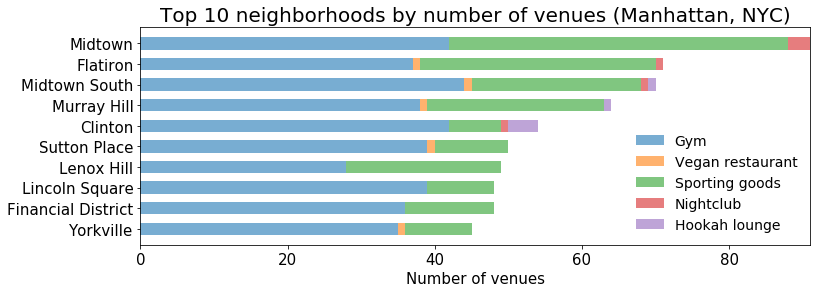

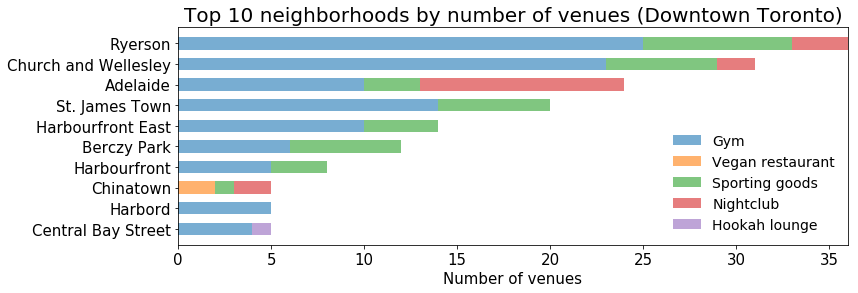

In [58]:
plot_stack_bar(df_nyc_plt, 'Manhattan, NYC',1)   # > 0: plot legend
plot_stack_bar(df_toronto_plt, 'Downtown Toronto',1)

#### Given the statistics of feature venues, we want to calculate per population number of venues in order to take out the population factor when comparing NYC with Toronto on a fair basis. We get demographic information from wikipedia that population in 2017:<br>
> Manhattan, NY: 1.66 Million (2017)<br>
> Downtown Toronto: 0.25 Million (2016)*

* https://www.cp24.com/news/downtown-population-will-nearly-double-by-2041-amid-building-and-baby-boom-keesmaat-1.2846605

In [59]:
popu_man = 1.66e6
popu_dtt = 0.25e6
nyc_venue_sum = df_nyc_feature['Total'].sum()
toronto_venue_sum = df_toronto_feature['Total'].sum()

venue_dens_nyc = nyc_venue_sum/popu_man*10000
venue_dens_dtt = toronto_venue_sum/popu_dtt*10000

print('Total number of venues (per population) in Manhattan is: %.2f' % venue_dens_nyc + ' per 10,000 people.')
print('Total number of venues (per population) in Downtown Toronto is: %.2f' % venue_dens_dtt + ' per 10,000 people.')

Total number of venues (per population) in Manhattan is: 6.77 per 10,000 people.
Total number of venues (per population) in Downtown Toronto is: 6.48 per 10,000 people.


#### It is shown that the per population figure of NYC is close to that of Toronto. The results indicate that people in Manhattan and Downtown Toronto have similar preference of a healthy lifestyle, and therefore similar openness to the idea of natural herb, such as Cannabis, based health products.    

### 2. Location convenience of feature venues by neighborhood

In [60]:
key_word_list = ['gym', 'vegan', 'sports', 'nightclub', 'hookah']
cities = ['nyc', 'toronto']

key_list = key_word_list[:-1]  
filt_word_list = ['Gym', 'Vegan', 'Sport', 'Nightclub', 'Hookah']

In [61]:
def feature_dist(city_name):
    
    for key, filt in zip(key_list, filt_word_list):
        df_file = 'df_' + city_name + '_' + key + '.csv'        
        df = pd.read_csv(df_file)
        df_fil_cat = df[df['Categories'].str.contains(filt)] # furter filter out irrelevant rows
        df_fil_nam = df[df['Name'].str.contains(filt)] 
        df_fil = pd.concat([df_fil_cat, df_fil_nam], axis = 0, ignore_index = True)
        df_fil = df_fil.drop_duplicates('ID')   # drop duplicate rows where 'ID' is identical       
    
        if key == key_list[0]:
            df_ret = df_fil.copy()
        else:
            df_ret = pd.concat([df_ret, df_fil], axis = 0, ignore_index = True)
   
        df_ret = df_ret.drop_duplicates('ID')   # drop duplicate rows where 'ID' is identical  
    
    return df_ret

The features of each relevant venue is saved below:

In [62]:
df_feat_dist_nyc = feature_dist('nyc')
df_feat_dist_toronto = feature_dist('toronto')

reduce_nei_name(df_feat_dist_toronto)

In [63]:
# get top 5 neighborhoods in NYC and Toronto
top5_nei_nyc = df_nyc_sort.loc[0:4,'Neighborhood'].to_list()
top5_nei_toronto = df_toronto_sort.loc[0:4,'Neighborhood'].to_list()

# select rows in the top 5 list
df_nyc_top5 = df_feat_dist_nyc[df_feat_dist_nyc['Neighborhood'].isin(top5_nei_nyc)]
df_toronto_top5 = df_feat_dist_toronto[df_feat_dist_toronto['Neighborhood'].isin(top5_nei_toronto)]

In [64]:
# return a dataframe with distance of each neighborhood in the city
def dist_dataframe(df, city):
    
    df_ret = pd.DataFrame(columns = [])
    if city == 'nyc':
        top_nei = top5_nei_nyc
    else:
        top_nei = top5_nei_toronto

    for nei in top_nei:
        
            df_temp = df[df['Neighborhood'] == nei]
            df_temp.reset_index(drop = True, inplace = True)
            df_ret[nei] = df_temp['Distance']
    
    return df_ret


In [65]:
df_nyc_dist = dist_dataframe(df_nyc_top5, 'nyc')
df_toronto_dist = dist_dataframe(df_toronto_top5, 'toronto')

In [66]:
def sns_plot_box(df, city):
    
    figsize = (5, 4) # figure size
    lfsize = 15  # label font size
    tfsize = 16  # title font size
    alp = 0.6   # transparency
    
    plt.figure(figsize = figsize)
    sns.boxplot(data = df, width = 0.4, boxprops = dict(alpha = alp))
                #figsize = figsize, fontsize = lfsize, rot = 45)
    
        
    plt.title('Disatance to neighborhood center: ' + city, fontsize = tfsize)
    plt.ylabel('Distance (M)', fontsize = lfsize)
    plt.xticks(fontsize = lfsize, rotation = 45, horizontalalignment = 'right')
    plt.yticks(fontsize = lfsize)
    plt.show()


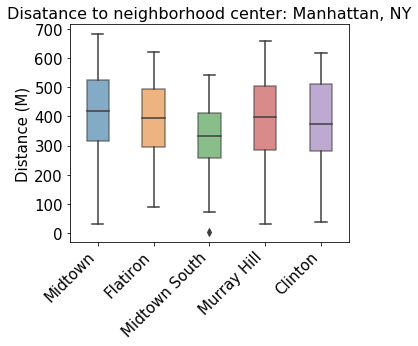

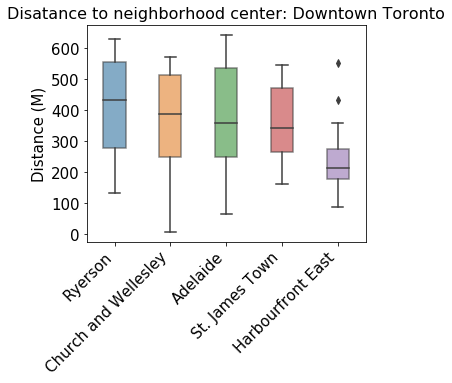

In [67]:
# make boxplot of distance by neighborhood
sns_plot_box(df_nyc_dist, 'Manhattan, NY')
sns_plot_box(df_toronto_dist, 'Downtown Toronto')

### 3. Visualize top neighborhoods on the map

Get top 10 neighborhoods data in NYC and Toronto.

In [68]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

In [69]:
# sort
df_nyc_sort_all = df_nyc_feature.sort_values(by = 'Total', axis = 0, ascending = False)
df_nyc_sort_all.reset_index(drop = True, inplace = True)

df_toronto_sort_all = df_toronto_feature.sort_values(by = 'Total', axis = 0, ascending = False)
df_toronto_sort_all.reset_index(drop = True, inplace = True)

df_nyc_sort_all.head()

,Neighborhood,Gym,Vegan,Sport,Nightclub,Hookah,Total
0,Midtown,42.0,0.0,46.0,3.0,0.0,91.0
1,Flatiron,37.0,1.0,32.0,1.0,0.0,71.0
2,Midtown South,44.0,1.0,23.0,1.0,1.0,70.0
3,Murray Hill,38.0,1.0,24.0,0.0,1.0,64.0
4,Clinton,42.0,0.0,7.0,1.0,4.0,54.0


In [70]:
# get a dataframe containing coordinates and venue statistics of all neighborhoods
df_nyc_ll_vnum = df_nyc_main.merge(df_nyc_sort_all, on = 'Neighborhood', how = 'left')
df_nyc_ll_vnum.head()

,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Total
0,Manhattan,Marble Hill,40.876551,-73.910660,2.0,0.0,1.0,0.0,0.0,3.0
1,Manhattan,Chinatown,40.715618,-73.994279,10.0,1.0,5.0,0.0,0.0,16.0
2,Manhattan,Washington Heights,40.851903,-73.936900,3.0,0.0,0.0,0.0,1.0,4.0
3,Manhattan,Inwood,40.867684,-73.921210,0.0,0.0,2.0,1.0,0.0,3.0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,6.0,0.0,5.0,1.0,1.0,13.0


In [104]:
address = 'Manhattan, NY'
geolocator = Nominatim(user_agent="nyc_explorer")

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NYC are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of NYC are 40.7900869, -73.9598295.


In [105]:
man_map = folium.Map(location = [latitude, longitude], tiles='cartodbpositron', zoom_start= 11)

man_geo = r'manhattan.geojson.txt' # geojson file

man_map.choropleth(
    geo_data = man_geo,
    data = df_nyc_ll_vnum, 
    columns = ['Neighborhood', 'Total'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd', 
    fill_opacity = 0.7, 
    line_opacity = 0.2,
    legend_name = 'Number of feature venues'
)
man_map

## Predicative modeling

### 1. Generating the dataset including all features: <br>
> Location <br> Breakdown of relevant venues (gym, vegan restaurant, sporting goods, nightclub, hookah lounge) <br> Popularity

First, let's take a look at the dataframe we have so far regarding features of each neighborhood.

In [73]:
df_nyc_ll_vnum.head()
df_feat_dist_nyc.head()

,Name,ID,Categories,Distance,Latitude,Longitude,Neighborhood
0,Planet Fitness,4aa00bcdf964a520103e20e3,Gym / Fitness Center,302,40.874088,-73.909137,Marble Hill
1,Astral Fitness & Wellness Center,4cf6ae55d3a8a1cd71a9d243,Gym,361,40.876705,-73.906372,Marble Hill
2,Seward Park High School Gym,4b984ce7f964a5207e3a35e3,College Gym,433,40.716889,-73.989426,Chinatown
3,Gym,4ee504e85c5cfa48fafcfd4f,Gym,241,40.716540,-73.996871,Chinatown
4,The Gym at The Crossroads,4fbb7cb2e4b0d498b403d874,Gym,366,40.714009,-73.990495,Chinatown


Then, let's put all features together for neighborhoods in NYC. The final dataframe (df_nyc_final_feat) will be used for predictive modeling.

In [74]:
df_dist = df_feat_dist_nyc.groupby('Neighborhood').mean()['Distance'].to_frame()
df_dist.reset_index(inplace = True)
df_dist.head()

,Neighborhood,Distance
0,Battery Park City,383.000000
1,Carnegie Hill,361.285714
2,Central Harlem,418.714286
3,Chelsea,408.300000
4,Chinatown,437.687500


In [75]:
df_nyc_final_feat = df_nyc_ll_vnum.copy()
df_nyc_final_feat = df_nyc_final_feat.merge(df_dist, on = 'Neighborhood', how = 'inner')
df_nyc_final_feat = df_nyc_final_feat.drop('Total', axis = 1)
df_nyc_final_feat.head()

,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Distance
0,Manhattan,Marble Hill,40.876551,-73.910660,2.0,0.0,1.0,0.0,0.0,426.666667
1,Manhattan,Chinatown,40.715618,-73.994279,10.0,1.0,5.0,0.0,0.0,437.687500
2,Manhattan,Washington Heights,40.851903,-73.936900,3.0,0.0,0.0,0.0,1.0,427.333333
3,Manhattan,Inwood,40.867684,-73.921210,0.0,0.0,2.0,1.0,0.0,351.666667
4,Manhattan,Hamilton Heights,40.823604,-73.949688,6.0,0.0,5.0,1.0,1.0,417.000000


Now let's do the same for neighborhoods in Toronto. The final dataframe is saved in 'df_toronto_final_feat'.

In [76]:
df_feat_dist_toronto = feature_dist('toronto') 
df_feat_dist_toronto.head()

,Name,ID,Categories,Distance,Latitude,Longitude,Neighborhood
0,Richmond Gym,4e21b1fe62e1964dbb6981cc,Gym,552,43.653485,-79.367416,"Harbourfront, Regent Park"
1,Corktown District Lofts Gym,4ffce4dee4b0f5828e1b8cc5,Gym,254,43.655652,-79.358125,"Harbourfront, Regent Park"
2,Gym @ The George,5abba87ef96b2c52184b9605,Gym,259,43.653410,-79.357630,"Harbourfront, Regent Park"
3,One32 Gym,554c4f84498ea4ff66cbca5a,Gym,439,43.654763,-79.366045,"Harbourfront, Regent Park"
4,Clear Spirit Gym,5242c03711d2a6ea89a19ce3,Gym,488,43.650345,-79.357900,"Harbourfront, Regent Park"


In [77]:
df_dist_t = df_feat_dist_toronto.groupby('Neighborhood').mean()['Distance'].to_frame()
df_dist_t.reset_index(inplace = True)
df_dist_t.head()

,Neighborhood,Distance
0,"Adelaide, King, Richmond",375.833333
1,Berczy Park,487.166667
2,"Cabbagetown, St. James Town",219.000000
3,Central Bay Street,433.500000
4,"Chinatown, Grange Park, Kensington Market",442.000000


In [72]:
df_toronto_main.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
1,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
2,Downtown Toronto,St. James Town,43.651494,-79.375418
3,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [78]:
df_toronto_final_feat = df_toronto_sort_all.merge(df_dist_t, on = 'Neighborhood', how = 'inner')
df_toronto_final_feat = df_toronto_main.merge(df_toronto_final_feat, on = 'Neighborhood', how = 'inner')
df_toronto_final_feat = df_toronto_final_feat.drop('Total', axis = 1)
df_toronto_final_feat.head()

,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Distance
0,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,5.0,0.0,3.0,0.0,0.0,356.250000
1,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,25.0,0.0,8.0,3.0,0.0,416.027778
2,Downtown Toronto,St. James Town,43.651494,-79.375418,14.0,0.0,6.0,0.0,0.0,348.950000
3,Downtown Toronto,Berczy Park,43.644771,-79.373306,6.0,0.0,6.0,0.0,0.0,487.166667
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4.0,0.0,0.0,0.0,1.0,433.500000


### 2. Setup machine learning model

#### From the exploratory data analysis section, we find that both cities have relevant venues that are indicative of healthy lifestyles and postive attitudes towards cannabis related health products. In this section, we want to group all neighborhoods into several clusters in order to further differentiate optimum locations for our potential business. 

First, we set up a K-means clustering method.

Import relevant libraries:

In [79]:
from sklearn.cluster import KMeans  # KMeans model
from sklearn.preprocessing import StandardScaler    # Data normalization/standarization 

Here, we define a function to do K-Means clustering:

In [80]:
# define a function to perform K-Means clustering 
# parameters: dataframe: df; index of the starting colum: col_start 
# return: labels; inertia: Sum of squared distances of samples to their closest cluster center 

def kmeans_cluster(df, col_start, clus_num, num_init):
    X = df.values[:,col_start:]
    X = np.nan_to_num(X)  # notice X should be ndarray type, fill NaN with zeros
    Clus_dataSet = StandardScaler().fit_transform(X) # data standarization

    # Use 'k-means++' as the initial guess of centroids, 
    # repeat the whole clustering process 12 times
    k_means = KMeans(init = "k-means++", n_clusters = clus_num, n_init = num_init)
    k_means.fit(Clus_dataSet)
    labels = k_means.labels_
    inertia = k_means.inertia_
    
    return labels, inertia

Scan the number of clusters to find the optimum K:

In [81]:
# Inertia as indicator of clustering accuracy
inert = []
k_range = range(1, 9)  # k from 1 to 8

# loop of k numbers
for clus_num in k_range:
    lab, iner = kmeans_cluster(df_nyc_final_feat, 4, clus_num, 12)
    inert.append(iner)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarnin

In [82]:
# produce a datafram of k and inertia for plotting
df_inertia = pd.DataFrame({'K clusters':k_range, 'Inertia':inert})
df_inertia

,K clusters,Inertia
0,1,240.000000
1,2,181.239850
2,3,145.416918
3,4,118.934319
4,5,94.466321
5,6,69.969284
6,7,61.137270
7,8,48.301604


Plot the Inertia vs. K relationship

In [83]:
def plot_inertia_k(df):
    figsize = (6,4)
    tfsize = 20
    lfsize = 15

    sns.set()
    plt.figure(figsize = figsize)
    sns.lineplot(x = 'K clusters', y = 'Inertia', data = df)
    plt.title('Inertia vs. K', fontsize = tfsize)
    plt.xlabel('K clusters', fontsize = lfsize)
    plt.ylabel('Inertia', fontsize = lfsize)
    plt.xticks(fontsize = lfsize)
    plt.yticks(fontsize = lfsize)
    plt.show()

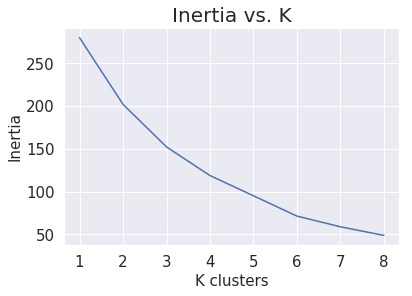

In [151]:
plot_inertia_k(df_inertia)

From the Inertia curve, we set K=6, and we rerun the KMeans model to get the labels of each neighborhood.

In [84]:
K_num = 6
labl, inert = kmeans_cluster(df_nyc_final_feat, 4, K_num, 12)
df_nyc_kmeans = df_nyc_final_feat.copy()
df_nyc_kmeans['Kmeans_label'] = labl
df_nyc_kmeans.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Distance,Kmeans_label
0,Manhattan,Marble Hill,40.876551,-73.910660,2.0,0.0,1.0,0.0,0.0,426.666667,0
1,Manhattan,Chinatown,40.715618,-73.994279,10.0,1.0,5.0,0.0,0.0,437.687500,0
2,Manhattan,Washington Heights,40.851903,-73.936900,3.0,0.0,0.0,0.0,1.0,427.333333,0
3,Manhattan,Inwood,40.867684,-73.921210,0.0,0.0,2.0,1.0,0.0,351.666667,0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,6.0,0.0,5.0,1.0,1.0,417.000000,0


**Finally, let's repeat the process for Downtown Toronto.**

Scan K to find the optimum cluster number:

In [91]:
df_toronto_final_feat.head()

,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Distance
0,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,5.0,0.0,3.0,0.0,0.0,356.250000
1,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,25.0,0.0,8.0,3.0,0.0,416.027778
2,Downtown Toronto,St. James Town,43.651494,-79.375418,14.0,0.0,6.0,0.0,0.0,348.950000
3,Downtown Toronto,Berczy Park,43.644771,-79.373306,6.0,0.0,6.0,0.0,0.0,487.166667
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4.0,0.0,0.0,0.0,1.0,433.500000


In [90]:
# Inertia as indicator of clustering accuracy
inert_t = []
k_range = range(1, 9)  # k from 1 to 8

# loop of k numbers
for clus_num in k_range:
    lab, iner = kmeans_cluster(df_toronto_final_feat, 4, clus_num, 12)
    inert_t.append(iner)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarnin

Then, plot the relationship between Inertia and K:

In [86]:
# produce a datafram of k and inertia for plotting
df_inertia_t = pd.DataFrame({'K clusters':k_range, 'Inertia':inert_t})
df_inertia_t

,K clusters,Inertia
0,1,66.000000
1,2,47.268623
2,3,33.829979
3,4,20.885678
4,5,11.130512
5,6,6.677295
6,7,4.487208
7,8,2.580205


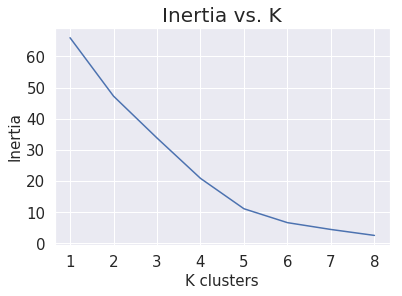

In [92]:
plot_inertia_k(df_inertia_t)

Here, we set K=5 and get the label of each neighborhood:

In [98]:
K_num_t = 5
labl, inert = kmeans_cluster(df_toronto_final_feat, 4, K_num_t, 12)
df_toronto_kmeans = df_toronto_final_feat.copy()
df_toronto_kmeans['Kmeans_label'] = labl
df_toronto_kmeans.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Distance,Kmeans_label
0,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,5.0,0.0,3.0,0.0,0.0,356.250000,2
1,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,25.0,0.0,8.0,3.0,0.0,416.027778,0
2,Downtown Toronto,St. James Town,43.651494,-79.375418,14.0,0.0,6.0,0.0,0.0,348.950000,0
3,Downtown Toronto,Berczy Park,43.644771,-79.373306,6.0,0.0,6.0,0.0,0.0,487.166667,0
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4.0,0.0,0.0,0.0,1.0,433.500000,3


### 3. Examine each neighborhood cluster

**First, let's define a function to display members and the averaged feature value in each cluster.**

In [87]:
# Define a function to examine statistics of each cluster
# parameters: kmeans dataframe: df; number of clusters: K_num
def examine_cluster(df, K_num):
    col_filter = ['Gym', 'Vegan', 'Sport', 'Nightclub', 'Hookah', 'Distance', 'Kmeans_label']
    for labl in range(K_num):
        nei_arry = df[df['Kmeans_label'] == labl]['Neighborhood'].values
    
        print('Cluster {}:'.format(labl))
        for nei in nei_arry.tolist():
            print('    ' + nei)
    print('')
    print('The averaged feature value of each cluster is:'.format(labl))
    print(df[col_filter].groupby('Kmeans_label').mean())

Now, we take a look at the clusters in Manhattan, NYC:

In [88]:
K_num = 6
print('The clusters in Manhattan, NYC are:')
examine_cluster(df_nyc_kmeans, K_num)

The clusters in Manhattan, NYC are:
Cluster 0:
    Marble Hill
    Chinatown
    Washington Heights
    Inwood
    Hamilton Heights
    Manhattanville
    Central Harlem
    Roosevelt Island
    Tribeca
    Little Italy
    Soho
    West Village
    Manhattan Valley
    Morningside Heights
    Turtle Bay
    Tudor City
    Hudson Yards
Cluster 1:
    Upper East Side
    Yorkville
    Lenox Hill
    Upper West Side
    Lincoln Square
    Gramercy
    Battery Park City
    Financial District
    Carnegie Hill
    Civic Center
    Sutton Place
Cluster 2:
    Murray Hill
    Chelsea
    Greenwich Village
    Midtown South
    Flatiron
Cluster 3:
    Midtown
Cluster 4:
    Clinton
    East Village
    Lower East Side
    Noho
Cluster 5:
    East Harlem
    Stuyvesant Town

The averaged feature value of each cluster is:
                    Gym     Vegan      Sport  Nightclub    Hookah    Distance
Kmeans_label                                                                 
0              7.3

From the cluster data, we can have a few insights:
> Cluster 3 has the highest averaged numbers of gym, sports goods, and nightclubs. As a result, it represents prime locations for our new business.

> Cluster 4 has the highest averaged number of hookah lounges, and relative high numbers of other feature venues. Thus, it could be a good location to attract young people who like cannabis based health products.

> Cluster 5 (Greenwich Village) has 5 vegan restaurants that might bring customers to our business.

Also, we want to see the cluster data of Downtown Toronto:

In [99]:
K_num_t = 5
print('The clusters in Downtown Toronto are:')
examine_cluster(df_toronto_kmeans, K_num_t)

The clusters in Downtown Toronto are:
Cluster 0:
    Ryerson, Garden District
    St. James Town
    Berczy Park
    Church and Wellesley
Cluster 1:
    Chinatown, Grange Park, Kensington Market
Cluster 2:
    Harbourfront, Regent Park
    Harbourfront East, Toronto Islands, Union Station
    Harbord, University of Toronto
    Cabbagetown, St. James Town
Cluster 3:
    Central Bay Street
Cluster 4:
    Adelaide, King, Richmond

The averaged feature value of each cluster is:
               Gym  Vegan  Sport  Nightclub  Hookah    Distance
Kmeans_label                                                   
0             17.0    0.0   6.50       1.25     0.0  403.399014
1              0.0    2.0   1.00       2.00     0.0  442.000000
2              5.5    0.0   1.75       0.00     0.0  285.823214
3              4.0    0.0   0.00       0.00     1.0  433.500000
4             10.0    0.0   3.00      11.00     0.0  375.833333


From the data above, we have the following findings:
> Cluster 2 has the highest averaged numbers of gyms and sporting goods, which seems to be a prime location for our business during day time business hours.

>  Cluster 4 (Adelaide/king/Richmond) has the highest number of nightclubs and much higher than that of the rest neighborhoods. This could mean a great opportunity for our business during night/late night time buisness hours.

**Lastly, we want to visualize cluster neighborhoods on the city map:**

In [26]:
# import libraries
import math 

First, we prepare the dataframe that includes all information for plotting.

In [96]:
df_nyc_clus_map = df_nyc_kmeans.copy()
df_nyc_clus_map['Total'] = df_nyc_clus_map[['Gym', 'Vegan', 'Sport', 'Nightclub', 'Hookah']].sum(axis = 1)
df_nyc_clus_map.head()

,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Distance,Kmeans_label,Total
0,Manhattan,Marble Hill,40.876551,-73.910660,2.0,0.0,1.0,0.0,0.0,426.666667,0,3.0
1,Manhattan,Chinatown,40.715618,-73.994279,10.0,1.0,5.0,0.0,0.0,437.687500,0,16.0
2,Manhattan,Washington Heights,40.851903,-73.936900,3.0,0.0,0.0,0.0,1.0,427.333333,0,4.0
3,Manhattan,Inwood,40.867684,-73.921210,0.0,0.0,2.0,1.0,0.0,351.666667,0,3.0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,6.0,0.0,5.0,1.0,1.0,417.000000,0,13.0


Then, we generate the map of Manhattan, NY. Each neighborhood is circle marked. The color of the marker indicates its cluster label, and the size of the circle indicates the averaged number of feature venues. 

> To generate a series of colors, we use colormaps provided by 'pyplot.cm'. For details: https://matplotlib.org/examples/color/colormaps_reference.html. 

> To convert color format from RGBA to Hex, we use: mpl.colors.to_hex()

In [100]:
# plot bubble map using folium
address = 'Manhattan, NY'
df = df_nyc_clus_map.copy()
    
# get geographical coordinates of the address
geolocator = Nominatim(user_agent="address_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude  

add_map = folium.Map(location = [latitude, longitude], tiles='cartodbpositron', zoom_start= 11)

# create a color list from colormap
color_list = plt.cm.Set2(np.linspace(0,1,K_num))       

for lat, lng, nei, klabel, total in zip(df['Latitude'], 
                                              df['Longitude'], 
                                              df['Neighborhood'],
                                              df['Kmeans_label'],
                                              df['Total']
                                             ):
        
    color = mpl.colors.to_hex(color_list[klabel])  
    label = 'Cluster {}: '.format(klabel) + nei
    folium.features.CircleMarker(
        location = [lat, lng],
        radius = math.sqrt(total), # define how big you want the circle markers to be
        color = color,
        fill = True,
        popup = label,
        fill_color = color,
        fill_opacity = 0.7
    ).add_to(add_map)
    
add_map

Now let's do the same for Downtown, Toronto:

In [101]:
# prepare the final dataframe
df_toronto_clus_map = df_toronto_kmeans.copy()
df_toronto_clus_map['Total'] = df_toronto_clus_map[['Gym', 'Vegan', 'Sport', 'Nightclub', 'Hookah']].sum(axis = 1)
df_toronto_clus_map.head()

,Borough,Neighborhood,Latitude,Longitude,Gym,Vegan,Sport,Nightclub,Hookah,Distance,Kmeans_label,Total
0,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,5.0,0.0,3.0,0.0,0.0,356.250000,2,8.0
1,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,25.0,0.0,8.0,3.0,0.0,416.027778,0,36.0
2,Downtown Toronto,St. James Town,43.651494,-79.375418,14.0,0.0,6.0,0.0,0.0,348.950000,0,20.0
3,Downtown Toronto,Berczy Park,43.644771,-79.373306,6.0,0.0,6.0,0.0,0.0,487.166667,0,12.0
4,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4.0,0.0,0.0,0.0,1.0,433.500000,3,5.0


In [106]:
# plot bubble map using folium
address = address = 'Toronto, ON'
df = df_toronto_clus_map.copy()
K_num_t = 5

# get geographical coordinates of the address
geolocator = Nominatim(user_agent="address_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude  

add_map = folium.Map(location = [latitude, longitude], tiles='cartodbpositron', zoom_start= 13)

# create a color list from colormap
color_list = plt.cm.Set2(np.linspace(0,1,K_num_t))       

for lat, lng, nei, klabel, total in zip(df['Latitude'], 
                                              df['Longitude'], 
                                              df['Neighborhood'],
                                              df['Kmeans_label'],
                                              df['Total']
                                             ):
        
    color = mpl.colors.to_hex(color_list[klabel])  
    label = 'Cluster {}: '.format(klabel) + nei
    folium.features.CircleMarker(
        location = [lat, lng],
        radius = 1.5*math.sqrt(total), # define how big you want the circle markers to be
        color = color,
        fill = True,
        popup = label,
        fill_color = color,
        fill_opacity = 0.7
    ).add_to(add_map)
    
add_map